In [96]:
#!g1.1
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt

In [97]:
#!g1.1
data = pd.read_csv("AAPL.csv", parse_dates=["Date"], index_col="Date")
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-11-22,10.952857,11.191429,10.923929,11.191429,9.486745,393075200
2010-11-23,11.087500,11.133929,10.948571,11.026071,9.346580,519447600
2010-11-24,11.142857,11.264286,11.133929,11.242857,9.530345,413725200
2010-11-26,11.205000,11.346429,11.176429,11.250000,9.536398,237585600
2010-11-29,11.267857,11.338571,11.120714,11.316786,9.593008,445785200


In [98]:
#!g1.1
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [99]:
#!g1.1
close_price = data["Adj Close"]

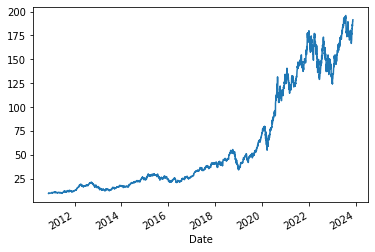

In [100]:
#!g1.1
close_price.plot();

In [101]:
#!g1.1
change_pct = close_price.pct_change()[1:]

<Axes: xlabel='Date'>

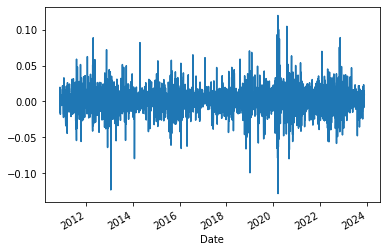

In [102]:
#!g1.1
change_pct.plot()

In [103]:
#!g1.1
mean_std = (1+1) ** (1/250) - 1

In [104]:
#!g1.1
obs_log_std = np.log(mean_std)

In [109]:
#!g1.1
with pm.Model(coords=dict(time=change_pct.index)) as model_simple:
    mean_return = pm.Normal("mean_std", 0, mean_std)
    day_log_volatility = pm.Normal("day_log_std", obs_log_std, 0.1)
    pm.Normal("returns", mean_return, pt.exp(day_log_volatility), observed=change_pct, dims="time")

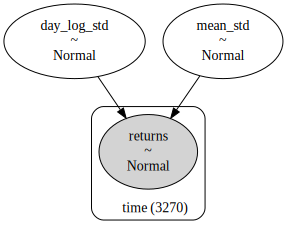

In [110]:
#!g1.1
pm.model_to_graphviz(model_simple)

In [111]:
#!g1.1
import pymc.sampling.jax

In [112]:
#!g1.1
with model_simple:
    trace = pymc.sampling.jax.sample_numpyro_nuts()

Compiling...
/usr/local/lib/python3.10/dist-packages/pymc/sampling/jax.py:678: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:05.778297
Sampling...
sample: 100%|██████████| 2000/2000 [00:13<00:00, 148.28it/s, 11 steps of size 1.07e-01. acc. prob=0.91]
Sampling time = 0:00:58.449683
Transforming variables...
Transformation time = 0:00:00.199387


In [113]:
#!g1.1
import arviz as az

array([[<Axes: title={'center': 'mean_std'}>,
        <Axes: title={'center': 'mean_std'}>],
       [<Axes: title={'center': 'day_log_std'}>,
        <Axes: title={'center': 'day_log_std'}>]], dtype=object)

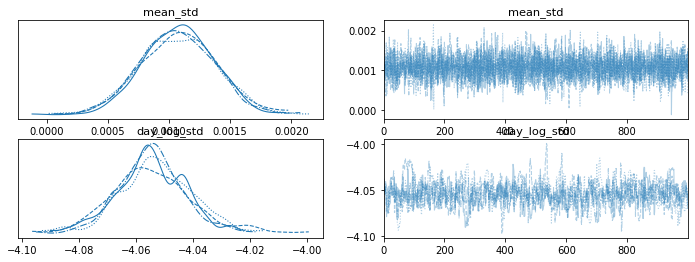

In [114]:
#!g1.1
az.plot_trace(trace)

In [115]:
#!g1.1
((trace.posterior["mean_std"]+1)**250-1).mean()

<xarray.DataArray 'mean_std' ()>
array(0.31186902)

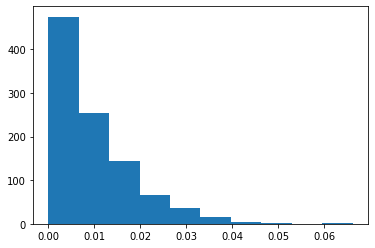

In [116]:
#!g1.1
alpha_dstd_prior = pm.Exponential.dist(100)
plt.hist(pm.draw(alpha_dstd_prior, 1000));

In [117]:
#!g1.1
time_baseline = pd.to_datetime("2024-1-1")
time_baseline

Timestamp('2024-01-01 00:00:00')

In [118]:
#!g1.1
change_pct.index.mean()

Timestamp('2017-05-23 14:06:23.119265792')

In [119]:
#!g1.1
days_time = change_pct.index - change_pct.index.mean()
min(days_time.days), max(days_time.days)

(-2374, 2371)

In [120]:
#!g1.1
2371 * .2

474.20000000000005

In [121]:
#!g1.1
required_m = int(3.42 * (2371 * 1.2) / 5)
required_m 

1946

In [122]:
#!g1.1
with pm.Model(coords=dict(time=change_pct.index)) as model:
    days_time = pm.ConstantData("numeric_time", (change_pct.index - change_pct.index.mean()).days, dims="time")

    mean_return = pm.Normal("mean_std", 0, mean_std)
    day_log_volatility = pm.Normal("day_log_std", obs_log_std, 0.1)
    
    alpha_dstd = pm.Exponential("alpha_dstd", 100)
    ls = pm.Gamma("ls_days", mu=30, sigma=5)
    
    kernel = pm.gp.cov.Matern32(1, ls=ls) * alpha_dstd
    
    gp = pm.gp.HSGP([required_m], [2371 * 1.2], drop_first=True, cov_func=kernel)
    delta_volatility = gp.prior("delta_volatility", days_time[:, None], dims="time")
    day_std = pm.Deterministic("day_std", pt.exp(day_log_volatility + delta_volatility), dims="time")
    pm.Normal("returns", mean_return, day_std, observed=change_pct, dims="time")

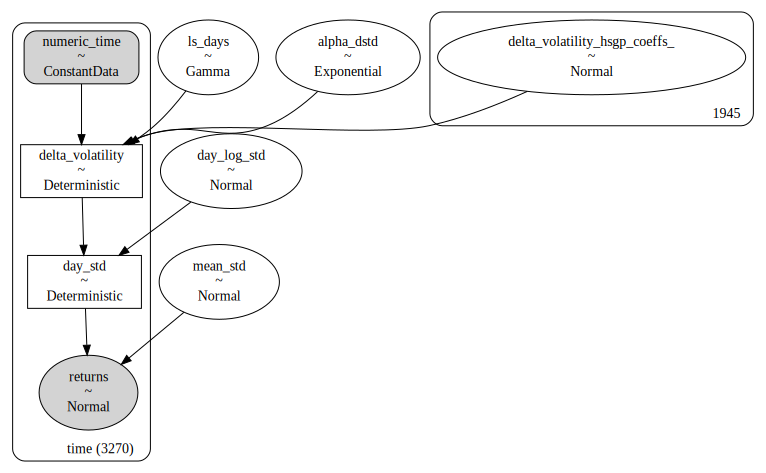

In [123]:
#!g1.1
pm.model_to_graphviz(model)

In [124]:
#!g1.1
with model:
    trace = pymc.sampling.jax.sample_numpyro_nuts(chains=2, chain_method="vectorized")

Compiling...
Compilation time = 0:01:09.304115
Sampling...
sample: 100%|██████████| 2000/2000 [03:50<00:00,  8.68it/s]
Sampling time = 0:03:56.771599
Transforming variables...
Transformation time = 0:00:03.229259


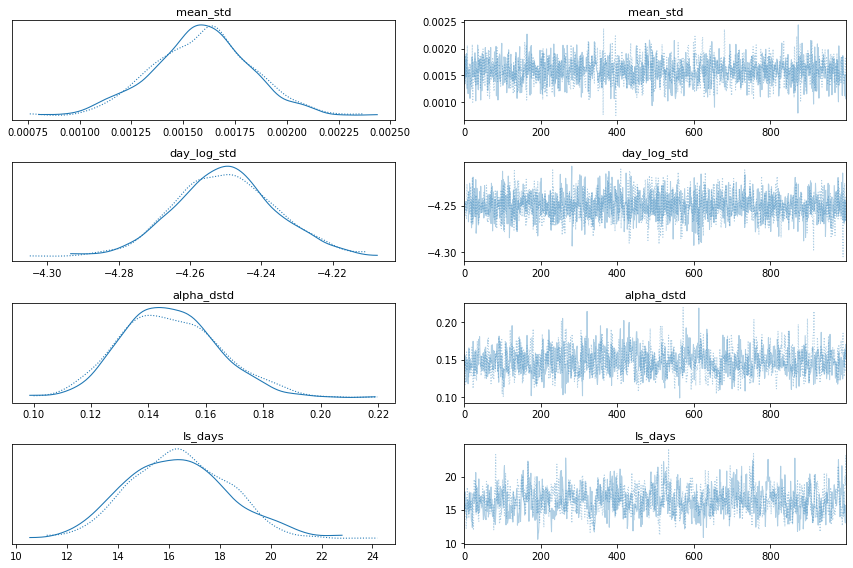

In [126]:
#!g1.1
az.plot_trace(trace, var_names=["mean_std", "day_log_std", "alpha_dstd", "ls_days"]);
plt.tight_layout()

In [127]:
#!g1.1
((trace.posterior["mean_std"]+1)**250-1).mean()

<xarray.DataArray 'mean_std' ()>
array(0.49003218)

In [129]:
#!g1.1
az.extract(trace.posterior)["day_std"].values

array([[0.01151797, 0.01217085, 0.01637124, ..., 0.01304237, 0.00923706,
        0.0182155 ],
       [0.0114541 , 0.01182843, 0.01597818, ..., 0.01300848, 0.00918274,
        0.01708506],
       [0.01089484, 0.01078867, 0.01494451, ..., 0.01266042, 0.00927688,
        0.01460922],
       ...,
       [0.00716474, 0.01670509, 0.00721169, ..., 0.01646597, 0.01750847,
        0.0084279 ],
       [0.00708915, 0.01665489, 0.00704732, ..., 0.01646828, 0.01767051,
        0.00844016],
       [0.0070429 , 0.01570252, 0.00697093, ..., 0.0172355 , 0.01805269,
        0.00831435]])

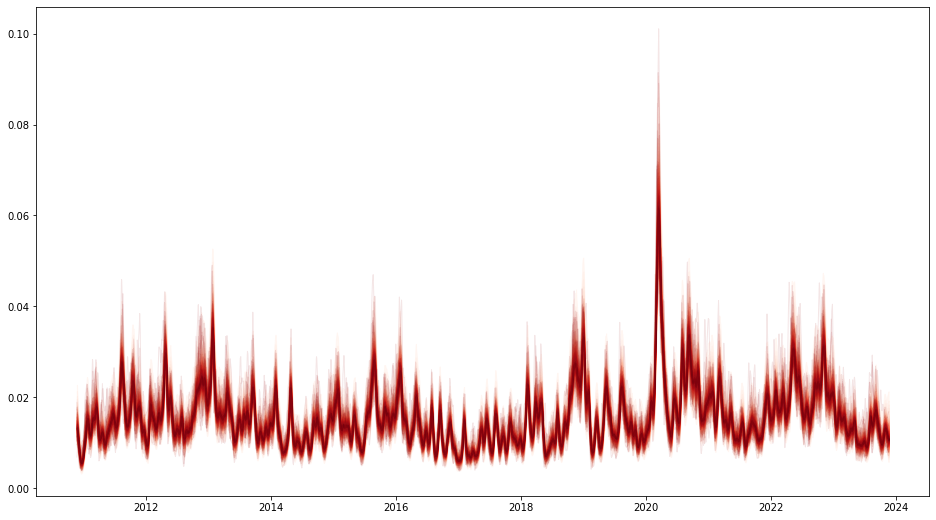

In [132]:
#!g1.1
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
pm.gp.util.plot_gp_dist(ax, az.extract(trace.posterior)["day_std"].values.T, x=change_pct.index.values);